# Lab 3: Build a Search Agent

In this lab, we'll use the Azure AI Agent Service to create an agent that is able to retrieve information from documents stored in Azure AI Search, a vector database. This pattern is known as retrieval augmented generation or RAG. The documents that we'll be searching are finance data.

### Part 1: Create the Azure AI Search Index

We'll start the lab by creating an Azure AI Search index, which will contain vectorized representations of our finance documents. The steps shown below to create the AI Search index are from the official Microsoft [documentation](https://learn.microsoft.com/en-us/azure/search/search-get-started-portal-import-vectors?tabs=sample-data-storage%2Cmodel-aoai%2Cconnect-data-storage)

#### Step 1
To begin, download the [documents](https://github.com/luckypamula/azure-ai-agents-labs/tree/main/data) that we'll store in the Azure AI Search index.

#### Step 2
Next, we'll upload the data documents to Azure Blob Storage, which Azure AI search connects to.
1. Navigate to your Storage Account (the one that was created automaticall during your AI Foundry project setup). 
2. Expand "Data Storage" in the side menu and click on "Containers". 
3. Create a new container named "financedata"

    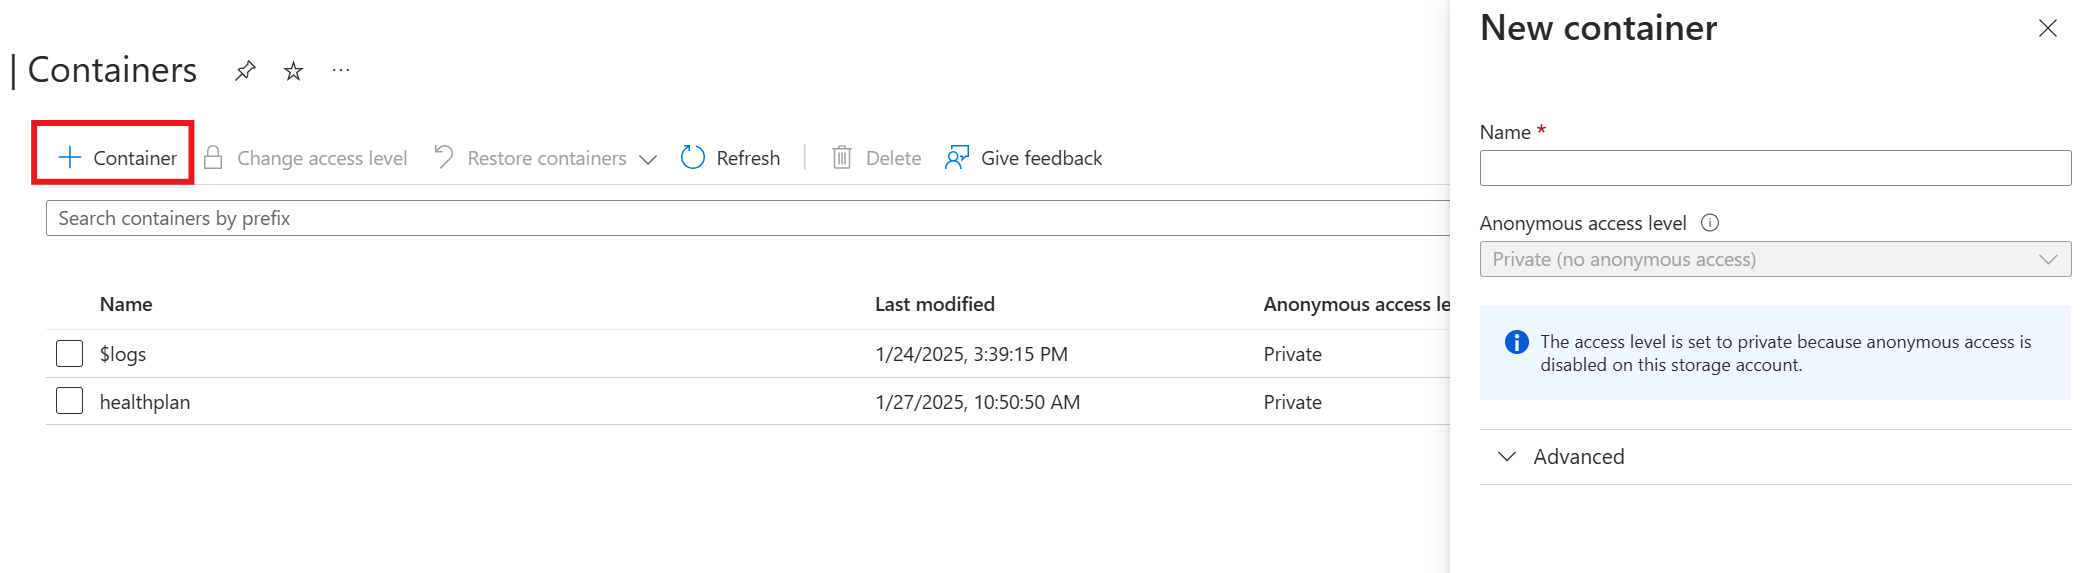
4. Click into the new container and upload the documents you downloaded.

#### Step 3
We need an embedding model in order to convert our documents into vectors that will be stored in Azure AI Search...luckily, we've already deployed a text-embedding-ada-002 model in Lab 1!

#### Step 4
Now we're ready to vectorize our documents.
1. Go to your Azure AI Search Service where your text-embedding-ada-002 model is deployed
1. On the **Overview page**, select **Import and vectorize data**.
1. On **Set up your data connection**, select **Azure Blob Storage**.
1. Specify your subscription, storage account, and the container that contains your finance data. 
1. Make sure **Authenticate using managed idenity is checked** and the **Managed identity type** is set to **System-assigned**.

    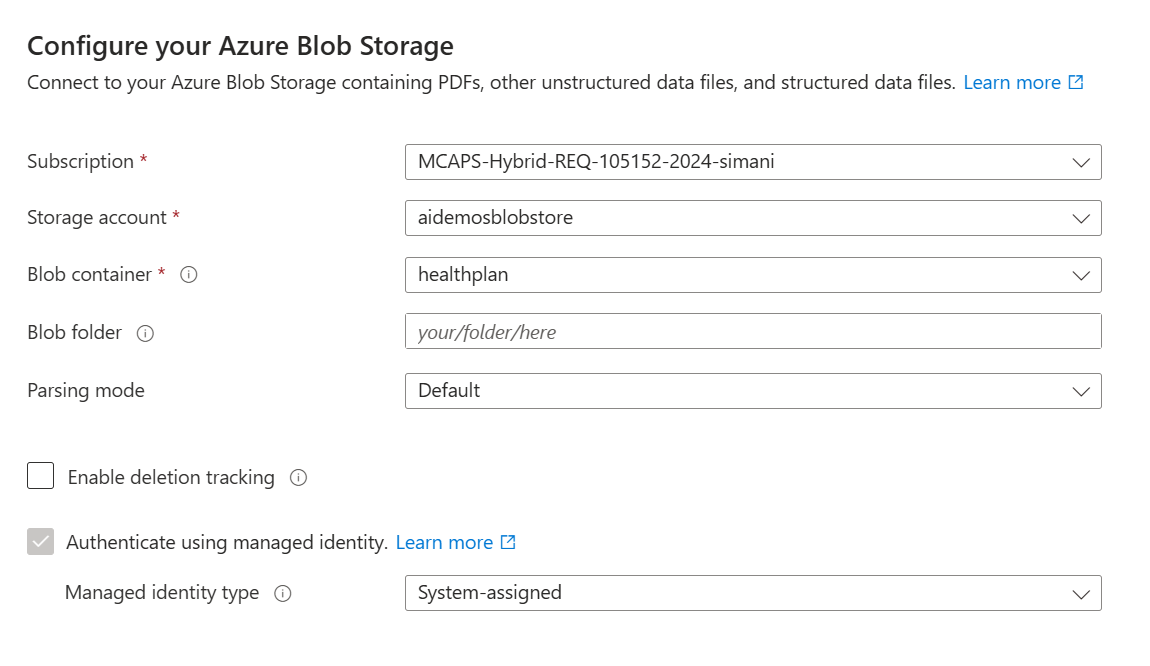
5. On the **Vectorize your text** page, select **Azure OpenAI** for **Kind**, select your subscription, and select the name of your Azure OpenAI Service.
6. For the **Model deployment** select `text-embedding-3-large`. 
7. The **Authentication type** should be set to **System-assigned identity**. 
8. Select the box next to the acknowledgement.

    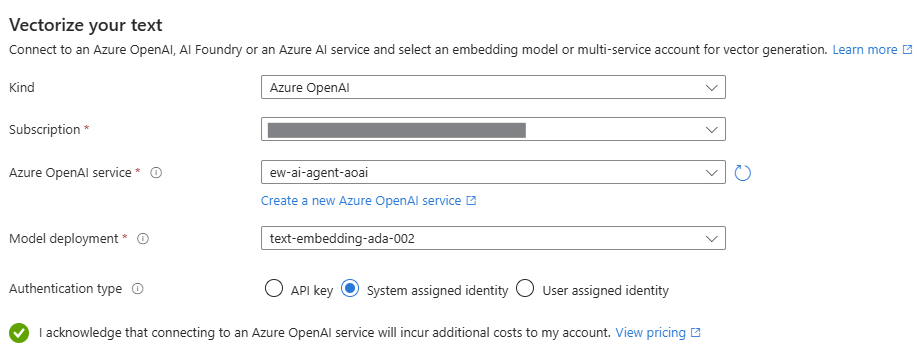
9. You can hit **Next** for the next two pages. When you get to the **Review and create** page, set **Objects name prefix** to **financedata-index**. 
10. Click **Create**. This will start the document indexing process which will vectorize your documents and create an index.

    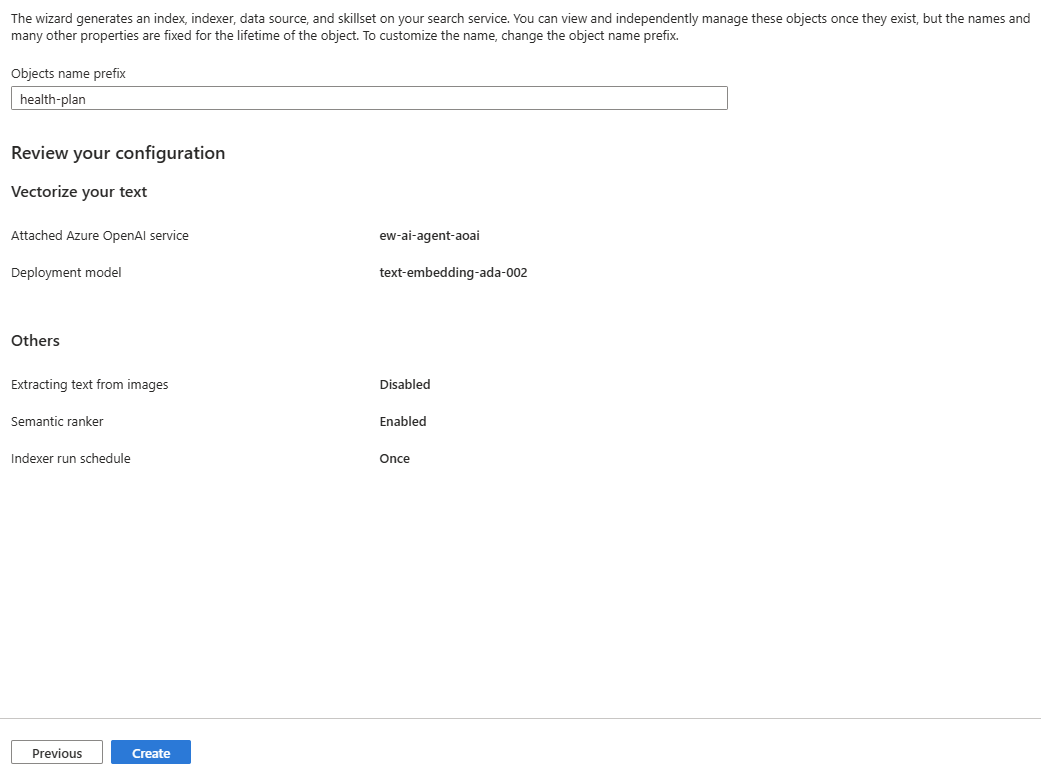


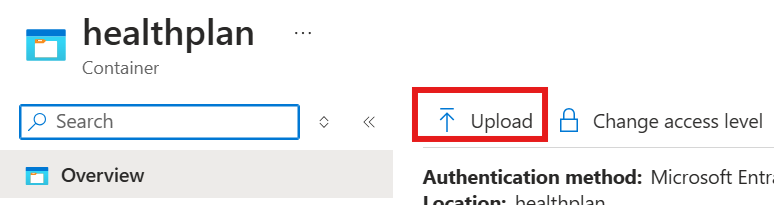

In [ ]:
class ValidationAgent:
    """
    A class to represent the Validation Agent.
    """
    @kernel_function(description='An agent that runs validation checks to ensure that the generated analyst report meets required standards.')
    def validate_report(self, report: str) -> str:
        """
        Validates the generated analyst report.
        Requirement: The report must include a detailed risk assessment.
        
        Parameters:
        report (str): The analyst report produced by the AnalystReportAgent.
        
        Returns:
        last_msg (json): The final message containing the validation result.
        """
        print("Calling ValidationAgent...")
        
        project_client = AIProjectClient.from_connection_string(
            credential=DefaultAzureCredential(),
            conn_str=os.environ["AIPROJECT_CONNECTION_STRING"],
        )
        
        validation_agent = project_client.agents.create_agent(
            model="gpt-4o",
            name="validation-agent",
            instructions="You are an expert agent that validates analyst reports. Return 'Pass' if the report includes a detailed risk assessment and meets all reporting standards, otherwise return 'Fail'. You must only return 'Pass' or 'Fail'.",
        )
        
        thread = project_client.agents.create_thread()
        
        message = project_client.agents.create_message(
            thread_id=thread.id,
            role="user",
            content=f"Validate that the generated analyst report includes a detailed risk assessment. Here is the report: {report}",
        )
        
        run = project_client.agents.create_and_process_run(thread_id=thread.id, agent_id=validation_agent.id)
        
        if run.status == "failed":
            print(f"Run failed: {run.last_error}")
        
        project_client.agents.delete_agent(validation_agent.id)
        
        messages = project_client.agents.list_messages(thread_id=thread.id)
        last_msg = messages.get_last_text_message_by_role("assistant")
        
        print("ValidationAgent completed successfully.")
        return last_msg

### Part 2: Create the Search Agent

Now that we've vectorized our documents and created an index, we can create a Search Agent that will retreive information about our data from the index.


#### Step 1: Load packages

In [ ]:
import os
from dotenv import load_dotenv
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential
from azure.ai.projects.models import AzureAISearchTool

load_dotenv() # Loads the environment variables and credentials we need to setup the agent

#### Step 2: Connect to your Azure AI Foundry project

In [2]:
# Connecting to our Azure AI Foundry project, which will allow us to use the deployed gpt-4o model
project_client = AIProjectClient.from_connection_string(
    credential=DefaultAzureCredential(),
    conn_str=os.environ["AIPROJECT_CONNECTION_STRING"],
    )

#### Step 3: Connect to your Azure AI Search index

In [ ]:
# Iterate through the connections in your project and get the connection ID of the Aazure AI Search connection.
conn_list = project_client.connections.list()
conn_id = ""
for conn in conn_list:
    if conn.connection_type == "CognitiveSearch":
        conn_id = conn.id
        print(f"Connection ID: {conn.id}")

# Connect to your Azure AI Search index
ai_search = AzureAISearchTool(index_connection_id=conn_id, index_name="")

#### Step 4: Define the search agent

In [ ]:
search_agent = project_client.agents.create_agent(
    model="gpt-4o",
    name="search-agent",
    instructions="You are a helpful agent that is an expert at searching documents.",
    tools=ai_search.definitions,
    tool_resources=ai_search.resources,
) 

#### Step 5: Chat with the search agent

Let's test our search agent by asking it to give us information about the data.

In [ ]:
# The name of the product we want to search for
product_name = 'Velo'

# Create a thread which is a conversation session between an agent and a user. 
thread = project_client.agents.create_thread()

# Create a message in the thread with the user asking for information about a specific product
message = project_client.agents.create_message(
    thread_id=thread.id,
    role="user",
    content=f"Tell me about the {product_name} product.", # The user's message
)
# Run the agent to process tne message in the thread
run = project_client.agents.create_and_process_run(thread_id=thread.id, assistant_id=search_agent.id)

# Check if the run was successful
if run.status == "failed":
    print(f"Run failed: {run.last_error}")

# Delete the agent when it's done running
project_client.agents.delete_agent(search_agent.id)

# Fetch all the messages from the thread
messages = project_client.agents.list_messages(thread_id=thread.id)

# Get the last message, which is the agent's resposne to the user's question
last_msg = messages.get_last_text_message_by_role("assistant")

# Display the agent's response
print('Agent:', last_msg.text.value)